# Imports

In [1]:
#for typing
from typing import List
from PIL import Image

import numpy as np
# training visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import DatasetFolder
import cv2

import torch
import torch.nn as nn
from torch import nn, optim
import lightning as L
import torch.nn.functional as F

import torchvision.models as models
from torchinfo import summary

torch.__version__

/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


'2.2.2+cu121'

# Load Data

In [2]:
from torchvision import transforms

transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225])])

def load_image(img_path:str):    
        np_img = cv2.imread(img_path) #CV2 to open and convert BMP mages into NUMPY    
        #np_img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        return Image.fromarray(np_img)  #we need Image for the transforms to work correctly

dset = DatasetFolder(root='../../datasets/NEUdata', loader = load_image, extensions = ('.bmp',), transform = transform)


In [3]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      dset, 
                      [1200, 600])

trainloader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

75
38


# Test Encoder/Decoder artichure

In [4]:
encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((55,55)),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(output_size=(32,32)),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 2, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
        )

summary(encoder, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 2, 16, 16]           --
+ Conv2d: 1-1                            [16, 6, 111, 111]         456
+ GELU: 1-2                              [16, 6, 111, 111]         --
+ AdaptiveAvgPool2d: 1-3                 [16, 6, 55, 55]           --
+ BatchNorm2d: 1-4                       [16, 6, 55, 55]           12
+ Conv2d: 1-5                            [16, 16, 28, 28]          880
+ GELU: 1-6                              [16, 16, 28, 28]          --
+ AdaptiveAvgPool2d: 1-7                 [16, 16, 32, 32]          --
+ BatchNorm2d: 1-8                       [16, 16, 32, 32]          32
+ Conv2d: 1-9                            [16, 2, 16, 16]           290
+ GELU: 1-10                             [16, 2, 16, 16]           --
Total params: 1,670
Trainable params: 1,670
Non-trainable params: 0
Total mult-adds (M): 102.12
Input size (MB): 9.63
Forward/backward pass size (MB): 1

In [5]:
decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 8, 
                               kernel_size=3, 
                               stride=4, 
                               padding=1, 
                               output_padding=2),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((64,64)),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((112,112)),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )


summary(decoder, input_size=(16, 2, 16, 16), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [16, 3, 224, 224]         --
+ ConvTranspose2d: 1-1                   [16, 8, 63, 63]           152
+ GELU: 1-2                              [16, 8, 63, 63]           --
+ AdaptiveAvgPool2d: 1-3                 [16, 8, 64, 64]           --
+ BatchNorm2d: 1-4                       [16, 8, 64, 64]           16
+ ConvTranspose2d: 1-5                   [16, 16, 128, 128]        1,168
+ GELU: 1-6                              [16, 16, 128, 128]        --
+ AdaptiveAvgPool2d: 1-7                 [16, 16, 112, 112]        --
+ BatchNorm2d: 1-8                       [16, 16, 112, 112]        32
+ ConvTranspose2d: 1-9                   [16, 3, 224, 224]         435
+ Sigmoid: 1-10                          [16, 3, 224, 224]         --
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
Total mult-adds (M): 665.06
Input size (MB): 0.03
Forward/backward pass size (MB):

# Write AutoEncoder

In [4]:
class Autoencoder(L.LightningModule):
    def __init__(self, config):
        super(Autoencoder, self).__init__()
        self.lr = config['lr']
        self.weight_decay = config['weight_decay']

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((55,55)),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(output_size=(32,32)),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 2, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 8, 
                               kernel_size=3, 
                               stride=4, 
                               padding=1, 
                               output_padding=2),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((64,64)),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((112,112)),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
        self.hist={'train':[], 'val':[]}
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        img, _ = batch
        recon = self.forward(img)
        # print(img.shape, recon.shape)
        loss = F.mse_loss(recon, img)
        self.log('train_loss', loss, prog_bar=True)

        if batch_idx==0:
            self.hist['train'].append((loss, img[:9], recon[:9]))


        return loss
    
    def validation_step(self, batch, batch_idx):
        img, _ = batch
        recon = self.forward(img)
        loss = F.mse_loss(recon, img)
        self.log('val_loss', loss, prog_bar=True)

        if batch_idx==0:
            self.hist['val'].append((loss, img[:9], recon[:9]))

        return {'val_loss': loss}
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr, 
                               weight_decay=self.weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.5, last_epoch=-1)
        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}
    
    @staticmethod
    def plot_encoder_decoder(outputs: List, title: str):
        fig= plt.figure(figsize=(9, 2))
        fig.suptitle(title)
        imgs = outputs[1].detach().cpu().numpy()
        recon = outputs[2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
                plt.subplot(2, 9, i+1)
                plt.axis("off")
                plt.imshow(item[0], cmap="gray")

        for i, item in enumerate(recon):
            plt.subplot(2, 9, 9+i+1)
            plt.axis("off")
            plt.imshow(item[0], cmap="gray")
     
    def plot_autoencoder_results(self, num_epochs):
        
        for k in range(0, num_epochs//5):
            Autoencoder.plot_encoder_decoder(self.hist["train"][k*5], title=f"train_{k}")
            Autoencoder.plot_encoder_decoder(self.hist["val"][k*5], title=f"val_{k}")

class NEUDataModule(L.LightningDataModule):
    def __init__(self, batch_size=128):
        super().__init__()
        self.data_dir = '/mnt/c/M3/Projects/Rowan/ADV MODELS/datasets/NEUdata'
        self.batch_size = batch_size
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

    def setup(self, stage=None):
        dset = DatasetFolder(root=self.data_dir, loader = load_image, extensions = ('.bmp',), transform = transform)

        self.train_set, self.val_set = random_split(
                    dset, 
                    [1200, 600])

    def train_dataloader(self):
        return  torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True, num_workers=1)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=1)

# Training

In [6]:
torch.cuda.is_available()

True

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /mnt/c/M3/Projects/Rowan/ADV MODELS/HM/HW5/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 75/75 [00:10<00:00,  7.21it/s, v_num=0, train_loss=0.381, val_loss=0.430]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 75/75 [00:10<00:00,  7.20it/s, v_num=0, train_loss=0.381, val_loss=0.430]


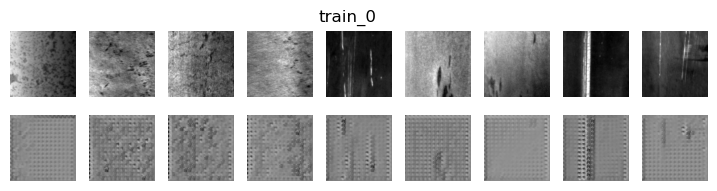

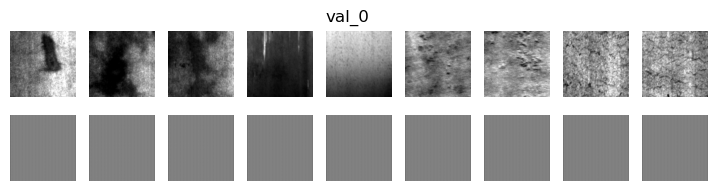

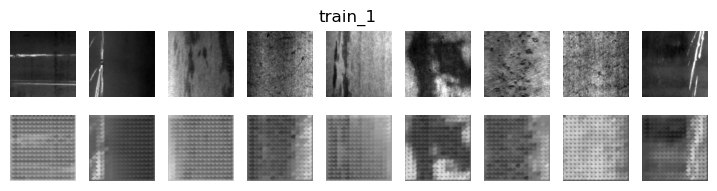

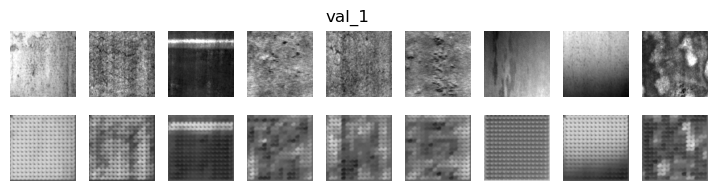

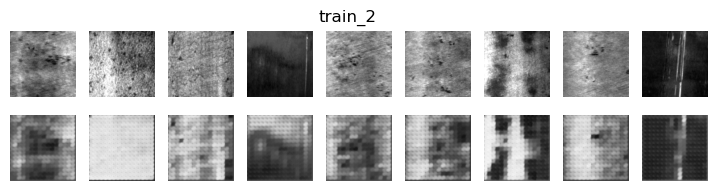

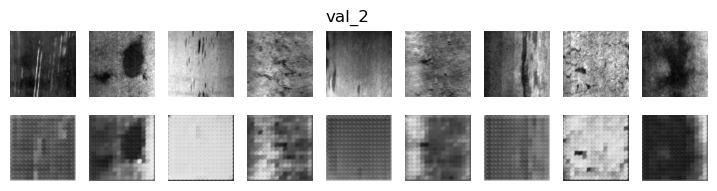

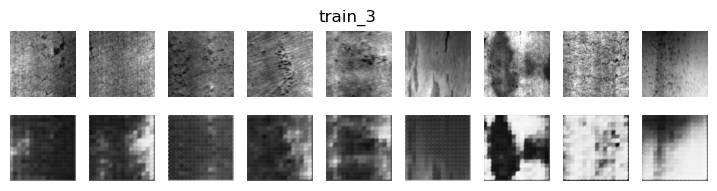

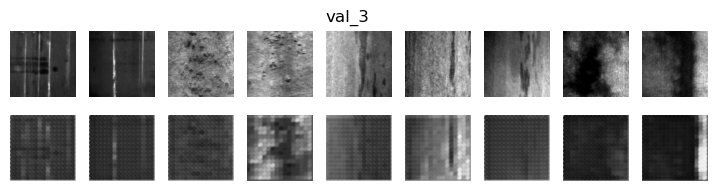

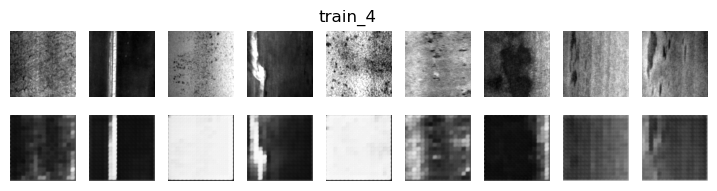

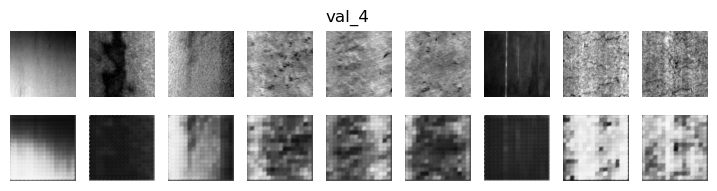

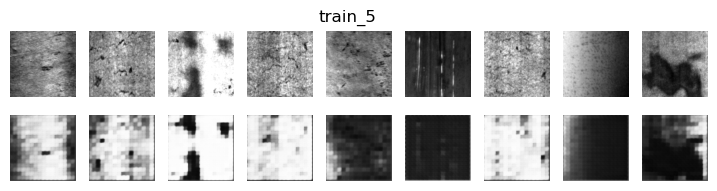

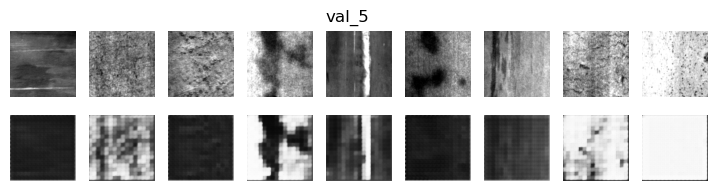

In [7]:
# I've changed the model for ray tuneing so now it will get config
autoencoder = Autoencoder()

# train model
trainer = L.Trainer(max_epochs=30, )
# I've changed the model for ray tuneing so now it will get DataModule instead of dataloader
trainer.fit(autoencoder, trainloader, valloader)
autoencoder.plot_autoencoder_results(30)

# Tuning with Ray

In [7]:
from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train import RunConfig, ScalingConfig, CheckpointConfig
from ray.train.torch import TorchTrainer

default_config = {
    "weight_decay": 1e-6,
    "lr": 5e-5,
    "batch_size": 16,
}

def train_func(config):
    dm = NEUDataModule(batch_size=config["batch_size"])
    autoencoder = Autoencoder(config)

    trainer = L.Trainer(
        devices="auto",
        accelerator="auto",
        strategy=RayDDPStrategy(),
        callbacks=[RayTrainReportCallback()],
        plugins=[RayLightningEnvironment()],
        enable_progress_bar=False,
        max_epochs=30,
    )
    trainer = prepare_trainer(trainer)
    trainer.fit(autoencoder, datamodule=dm)

search_space = {
    "lr": tune.loguniform(1e-6, 1e-1),
    "batch_size": tune.choice([16, 32, 64]),
    "weight_decay": tune.choice([1e-6])
}

# The maximum training epochs
num_epochs = 30

# Number of samples from parameter space
num_samples = 10

scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)


scaling_config = ScalingConfig(
    num_workers=1, use_gpu=True, resources_per_worker={"CPU": 10, "GPU": 1}
)

run_config = RunConfig(
    checkpoint_config=CheckpointConfig(
        num_to_keep=2,
        checkpoint_score_attribute="val_loss",
        checkpoint_score_order="min",
    ),
)


# Define a TorchTrainer without hyper-parameters for Tuner
ray_trainer = TorchTrainer(
    train_func,
    scaling_config=scaling_config,
    run_config=run_config,
)

def tune_NEU_asha(num_samples=10):
    scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

    tuner = tune.Tuner(
        ray_trainer,
        param_space={"train_loop_config": search_space},
        tune_config=tune.TuneConfig(
            metric="val_loss",
            mode="min",
            num_samples=num_samples,
            scheduler=scheduler,
        ),
    )
    return tuner.fit()

In [8]:
results = tune_NEU_asha(num_samples=num_samples)

(TrainTrainable pid=72585) /home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
(TrainTrainable pid=72585)   warn(
(RayTrainWorker pid=72906) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=72585) Started distributed worker processes: 
(TorchTrainer pid=72585) - (ip=172.20.7.104, pid=72906) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=72906) [W Utils.hpp:133] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (func

In [10]:
results.get_best_result(metric="val_loss", mode="min")

Result(
  metrics={'train_loss': 0.40551847219467163, 'val_loss': 0.3812931180000305, 'epoch': 29, 'step': 2250},
  path='/home/woreom/ray_results/TorchTrainer_2024-04-18_21-39-43/TorchTrainer_b4607_00000_0_batch_size=16,lr=0.0022,weight_decay=0.0000_2024-04-18_21-39-47',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/woreom/ray_results/TorchTrainer_2024-04-18_21-39-43/TorchTrainer_b4607_00000_0_batch_size=16,lr=0.0022,weight_decay=0.0000_2024-04-18_21-39-47/checkpoint_000029)
)

# Transfer Learn
I'm not quite sure what e) means, but I'm guessing we want to do transfer learning on ImageNet100.

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 K 
1 | decoder | Sequential | 1.8 K 
-----------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/woreom/miniconda3/envs/adv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


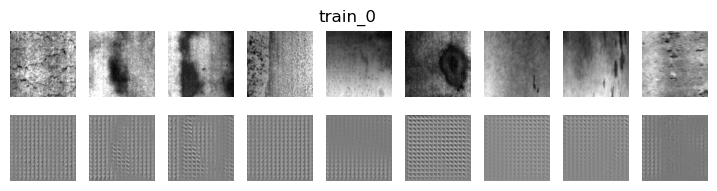

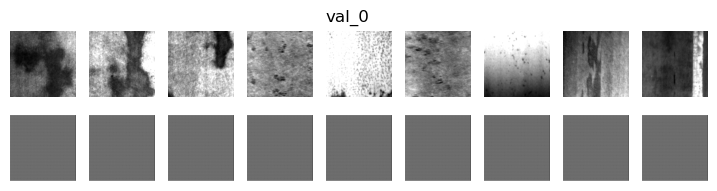

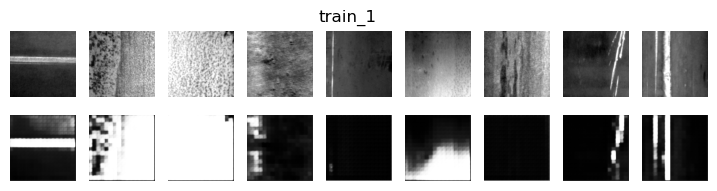

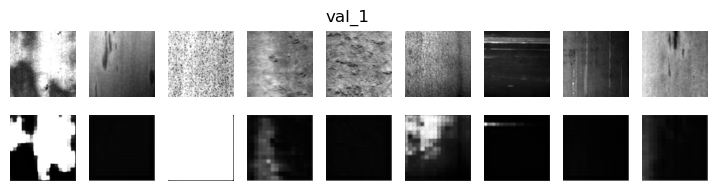

In [5]:
default_config = {
    "weight_decay": 1e-6,
    "lr": 0.0022,
    "batch_size": 16,
}
autoencoder = Autoencoder(default_config)
# train model
# overfits after 10 epochs with the new learning rate
trainer = L.Trainer(max_epochs=10, )
# I've changed the model for ray tuneing so now it will get DataModule instead of dataloader
trainer.fit(autoencoder, trainloader, valloader)
autoencoder.plot_autoencoder_results(10)

In [6]:
torch.cuda.empty_cache()

ROOT_FOLDER =  "../../../datasets/ImageNet100/"

ds_train = DatasetFolder(ROOT_FOLDER+'/train.X4/', loader=load_image, extensions = ('.JPEG','.jpeg', '.jpg'), 
                         transform=transforms.Compose([
                                   transforms.CenterCrop(224),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor()]))

ds_val = DatasetFolder(ROOT_FOLDER+'/val.X/', loader=load_image, extensions = ('.JPEG','.jpeg', '.jpg'),
                    transform=transforms.Compose([transforms.CenterCrop(224),
                                                  transforms.ToTensor() ]))

trainloader = torch.utils.data.DataLoader(
                    ds_train, 
                    batch_size=16, 
                    shuffle=True)

valloader = torch.utils.data.DataLoader(
                    ds_val, 
                    batch_size=16, 
                    shuffle=True)

print(len(trainloader))
# out: 2500
print(len(valloader))
# out: 625

2032
313


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 K 
1 | decoder | Sequential | 1.8 K 
---------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


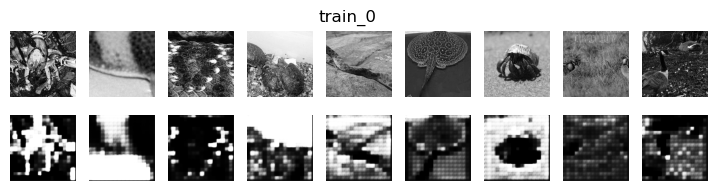

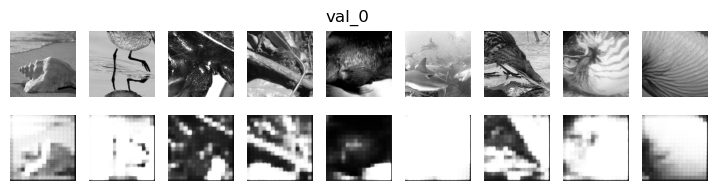

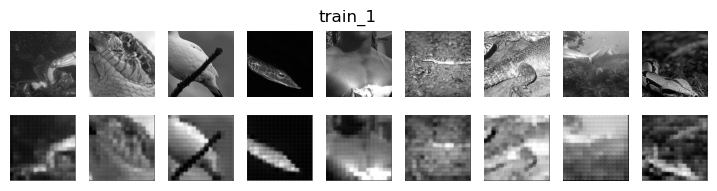

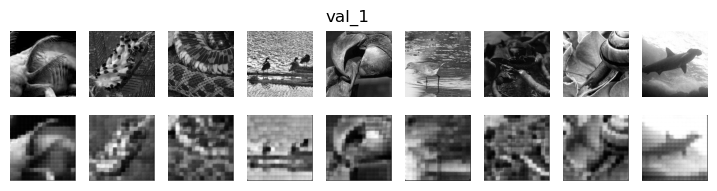

In [7]:
# reset the images
autoencoder.hist={'train':[], 'val':[]}

# train model
trainer = L.Trainer(max_epochs=10, )
trainer.fit(autoencoder, trainloader, valloader)
autoencoder.plot_autoencoder_results(10)

So the last time my autoencoder padding was weird, I had stride equal to odd numbers padding more than 1 and kernels equal to even numbers, all to make the encoder output dimension to be 512 and the decoder output dimension to be the same as the original image, this time I changed the MaxPooling layers which addaptivePooling, In this way I could control the dimensions easier and correct the weird arguments which definetly affected my results. Then I add addaptivePooling to the decoder as well(Online must examples didn't use any normalization or regularization on their decoder to be more like a mirror of the encoder but since this time we had to refine the model, I stray away from this just a little bit). For the decoder last activation function should be sigmoid but I also added another activation function before it (addaptivepooling) just to see what happens, the results were not good. For the encoder or embeddings in general it is suggested not to have a normalization because having a little bias is good but I added a normalization layer to see what happens, the results were not good or I should say not as good as without these layers. Lastly, I played around with the learning rate and visually saw that the decoded images of lr=5e-5 was better however raytune found 0.0022 a better learning rate. the first result was with lr=5e-5 and the second one was with lr=0.0022 but I trained it for less epochs. I also trained the newer model with my previous code to know how should my model behave. the lowest loss I got was around 0.36 which was significantly lower than the last assignment which was around 0.5.

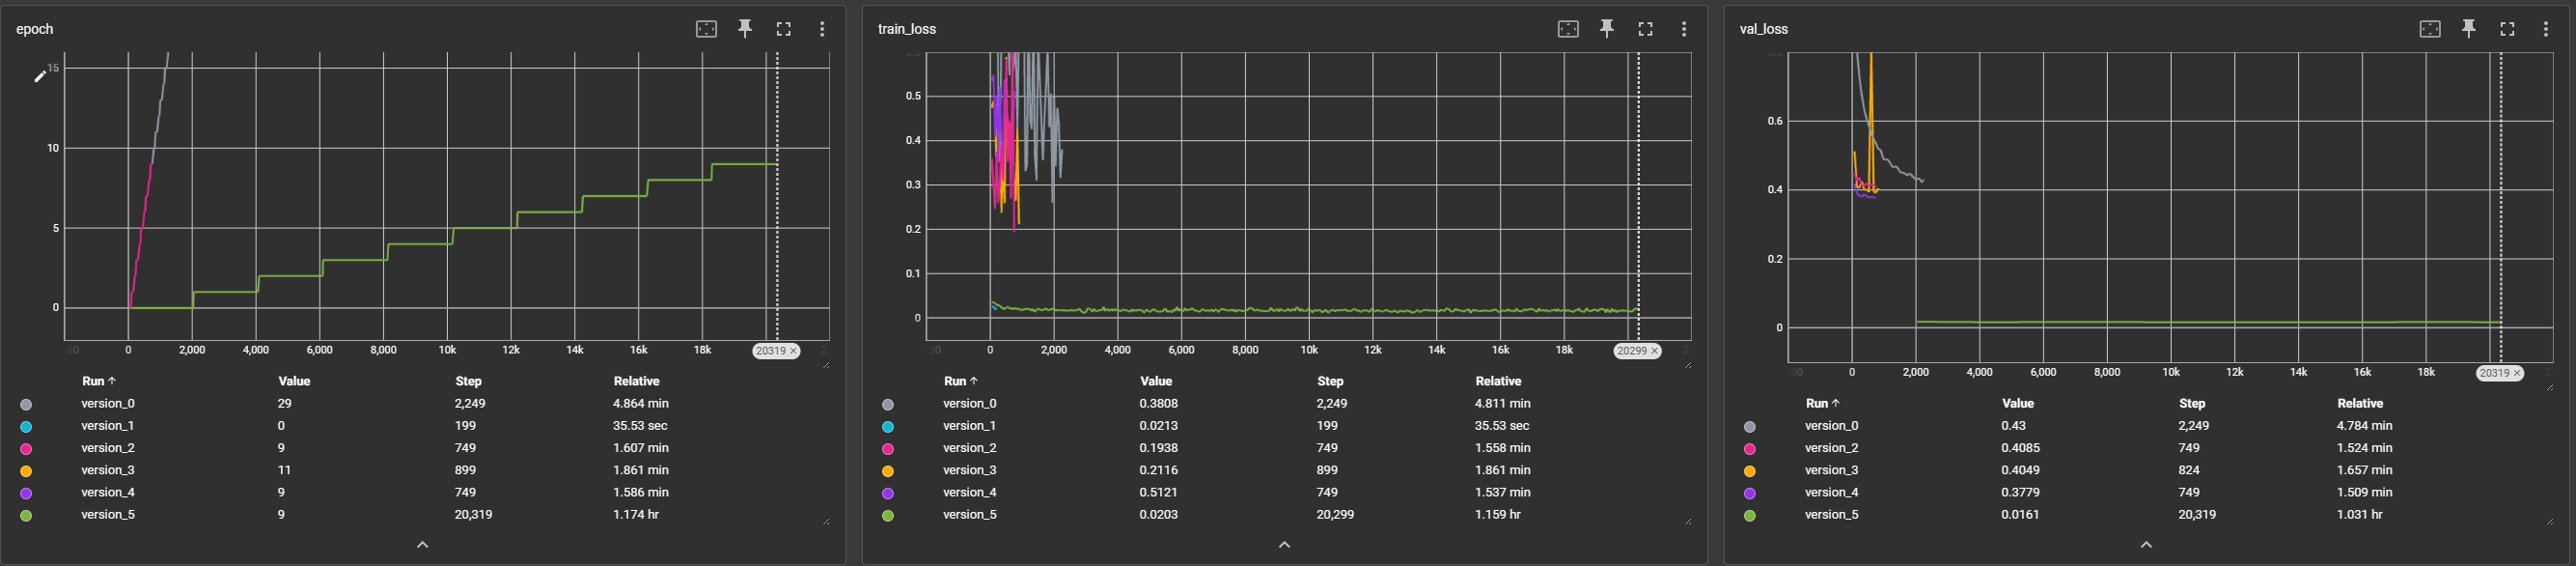

# Test (perivous homowork's code)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=2, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((55,55)),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(output_size=(32,32)),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 2, kernel_size=3, stride=2, padding=1),
            nn.GELU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2, 8, 
                               kernel_size=3, 
                               stride=4, 
                               padding=1, 
                               output_padding=2),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((64,64)),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((112,112)),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def eval_model(self, epoch: int, data_loader: torch.utils.data.DataLoader, optimizer: torch.optim,
                   criterion: nn.modules.loss, device: torch.device, mode: str):
        
        with tqdm(data_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            n_loss = 0
            loss_ctr = 0
            for img, _ in tepoch:
                img = img.to(device)

                recon = self.forward(img)
                loss = criterion(recon, img)
                
                if mode == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                n_loss += loss.item()
                loss_ctr += 1

                tepoch.set_postfix(mode=mode, loss=n_loss/loss_ctr)

        if epoch % self.eval_step == 0 or mode == "test":
            self.hist[mode].append((n_loss/loss_ctr, img[:9], recon[:9]))
    
    @staticmethod
    def plot_encoder_decoder(outputs: List, title: str):
        fig= plt.figure(figsize=(9, 2))
        fig.suptitle(title)
        imgs = outputs[1].detach().cpu().numpy()
        recon = outputs[2].detach().cpu().numpy()
        for i, item in enumerate(imgs):
                plt.subplot(2, 9, i+1)
                plt.axis("off")
                plt.imshow(item[0], cmap="gray")

        for i, item in enumerate(recon):
            plt.subplot(2, 9, 9+i+1)
            plt.axis("off")
            plt.imshow(item[0], cmap="gray")
            
    def plot_autoencoder_results(self, num_epochs):
        
        for k in range(0, num_epochs//self.eval_step):
            Autoencoder.plot_encoder_decoder(self.hist["train"][k], title=f"train_{k}")
            Autoencoder.plot_encoder_decoder(self.hist["val"][k], title=f"val_{k}")
    
    def fit(self, train_loader, val_loader, optimizer: torch.optim, loss: nn.modules.loss, num_epochs: int, eval_step: int):
        self.eval_step = eval_step
        # check to run training on cpu or gpu
        device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        self.to(device)
        # Point to training loop video
        self.hist = {"train":[], "test":[], "val":[]}
        
        for epoch in range(1, num_epochs+1):
            self.train()
            self.eval_model(epoch = epoch, data_loader = train_loader, optimizer = optimizer,
                            criterion = loss, device = device, mode = "train")
            
            if epoch % self.eval_step == 0:
                self.eval()
                self.eval_model(epoch = epoch, data_loader = val_loader, optimizer = optimizer,
                                criterion = loss, device = device, mode = "val")
        
        
        self.plot_autoencoder_results(num_epochs)

Epoch 30: 100%|██████████| 38/38 [00:03<00:00, 11.14batch/s, loss=0.423, mode=val]


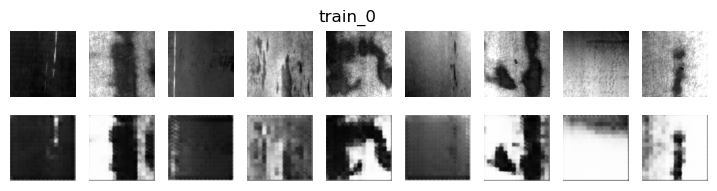

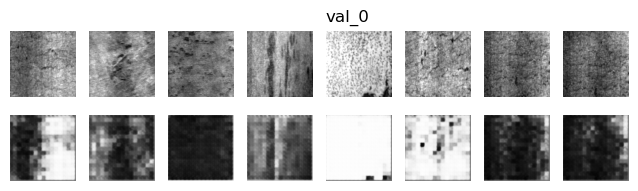

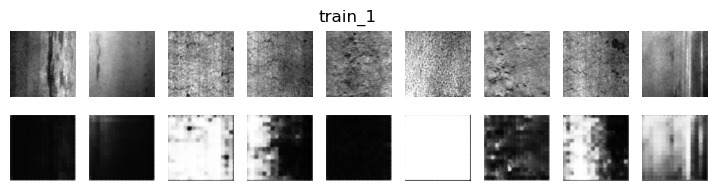

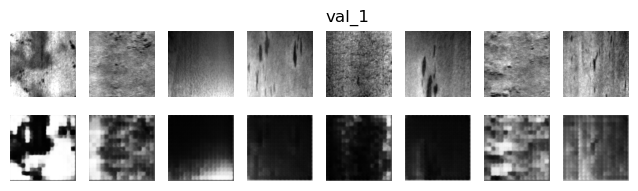

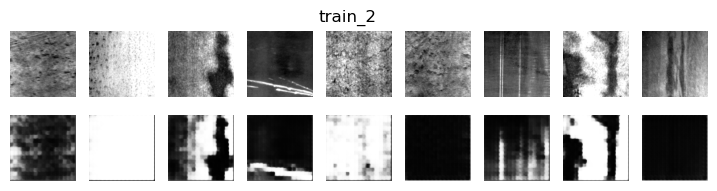

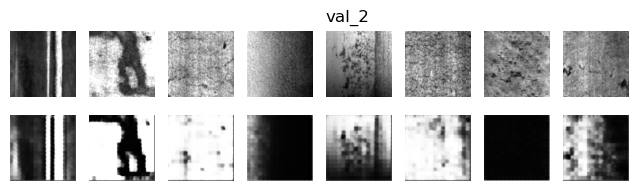

In [7]:
autoencoder = Autoencoder()

loss = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr=1e-4, 
                             weight_decay=1e-6)

autoencoder.fit(train_loader=trainloader, val_loader=valloader,
                optimizer=optimizer, loss=loss, num_epochs=30, eval_step=10)